<table>
    <tr>
        <td>
            <img src="extra/logo_scgis.png" width="100" height="100" />
        </td>
        <td>
            <center>
                <font size = 1>
                8 НОЯБРЯ 2020<br>
                АНТИКОНФЕРЕНЦИЯ СООБЩЕСТВА ПРИРОДООХРАННЫХ ГИС В РОССИИ<br><br>
                </font>
                <font size = 3>
                Материалы к вебинару<br> <b>Получение и обработка данных дистанционного зондирования с помощью Python:<br>строим простую систему мониторинга окружающей среды в Jupyter Notebook.</b><br><br>
                </font>
                <font size = 2>
                <b>Эдуард Казаков</b><br>
                NextGIS, Государственный гидрологический институт
                </font>
            </center>
        </td>
    </tr>
</table>

# Часть 1. Экспериментируем!

### Импортируем библиотеки, возможности которых нам будут необходимы

In [35]:
# Инструменты для работы с файловой системой
import os

# Библиотеки для работы с векторными и растровыми данными
import gdal, ogr

# Библиотека для взаимодействия с интернет-ресурсами
import requests

# Библиотека для разбора XML документов
import xml.etree.ElementTree as etree

# Библиотека для работы с датами и временем
from datetime import datetime

# Библиотека для работы с архивами
import zipfile

# Библиотека для построения графиков 
import matplotlib.pyplot as plt

# Библиотека для работы с матрицами
import numpy as np

### Для начала подготовим функции, которые позволят как-нибудь легко и просто загружать данные.

Начнём с данных Sentinel-2. Официально они распространяются с помощью портала <a href="https://scihub.copernicus.eu/">The Copernicus Open Access Hub</a>, который предоставляет различные способы получения данных, в том числе - через графический веб-интерфейс. Но это нам не подходит - нам нужна автоматизация. По этому случаю есть официальное <a href="scihub.copernicus.eu/userguide/8BatchScripting">API</a>, то есть способ получать данные программно. Это HTTP API, то есть оно принимает запросы по протоколу HTTP, а слать такие запросы может и обычный веб-браузер. Попробуйте, к примеру, обратиться по адресу <a href="https://scihub.copernicus.eu/dhus/search?q=*&rows=25">https://scihub.copernicus.eu/dhus/search?q=*&rows=25</a> и ввести логин/пароль.

Вы получите ответ на запрос в машиночитаемом формате XML. А запрос подразумевал информацию о последних 25 сценах, добавленных в систему, без дополнительных указаний. Можно добавлять разные отдельные условия, сужающие запрос. Например, вот так <a href="https://scihub.copernicus.eu/dhus/search?q=*&rows=25&platformname=Sentinel-2">https://scihub.copernicus.eu/dhus/search?q=*&rows=25&platformname=Sentinel-2</a>, дополнительно указав параметр platformname, мы получим только описание сцен со спутников Sentinel-2

Значит, нам нужно написать код, который будет формировать такой запрос и разбирать полученные данные. Для начала - эксперименты!

In [78]:
# Пробуем просто выполнить такой запрос
r = requests.get('https://scihub.copernicus.eu/dhus/search?q=(platformname:Sentinel-2)&rows=25', auth=('spbgeotex','SpbGeoTex0'))

In [53]:
type(r)

requests.models.Response

In [54]:
# что нам вернулось? Код статуса
r.status_code

200

In [55]:
# содержимое, первая тысяча символов
r.content[0:1000]

b'<?xml version="1.0" encoding="utf-8"?><feed xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/" xmlns="http://www.w3.org/2005/Atom">\n<title>Sentinels Scientific Data Hub search results for: platformname:Sentinel-2</title>\n<subtitle>Displaying 0 to 24 of 22831334 total results. Request done in 0 seconds.</subtitle>\n<updated>2020-11-05T17:20:53.714Z</updated>\n<author>\n<name>Sentinels Scientific Data Hub</name>\n</author>\n<id>https://scihub.copernicus.eu/dhus/search?q=platformname:Sentinel-2</id>\n<opensearch:totalResults>22831334</opensearch:totalResults>\n<opensearch:startIndex>0</opensearch:startIndex>\n<opensearch:itemsPerPage>25</opensearch:itemsPerPage>\n<opensearch:Query role="request" searchTerms="platformname:Sentinel-2" startPage="1"/>\n<link rel="self" type="application/atom+xml" href="https://scihub.copernicus.eu/dhus/search?q=platformname:Sentinel-2&amp;start=0&amp;rows=25"/>\n<link rel="first" type="application/atom+xml" href="https://scihub.copernicus.eu/dhus/se

Это XML-код. Нам нужно его превратить во что-то вменяемое, с чем можно было бы работать средствами Python. Для этого хорошо подходит стандартная библиотека xml

In [13]:
# читаем весь пришедший текст как XML-дерево
answer_data = etree.ElementTree(etree.fromstring(r.content)).getroot()

# Ищем в нём все отдельные записи
entries = answer_data.findall('{http://www.w3.org/2005/Atom}entry')

In [14]:
# что за записи?
entries

[<Element '{http://www.w3.org/2005/Atom}entry' at 0x000002D82A5E4188>,
 <Element '{http://www.w3.org/2005/Atom}entry' at 0x000002D82A5EFBD8>,
 <Element '{http://www.w3.org/2005/Atom}entry' at 0x000002D82A5EE638>,
 <Element '{http://www.w3.org/2005/Atom}entry' at 0x000002D82A6EE958>,
 <Element '{http://www.w3.org/2005/Atom}entry' at 0x000002D82A5DE818>,
 <Element '{http://www.w3.org/2005/Atom}entry' at 0x000002D82A5A2048>,
 <Element '{http://www.w3.org/2005/Atom}entry' at 0x000002D82A5B29F8>,
 <Element '{http://www.w3.org/2005/Atom}entry' at 0x000002D82A5B6408>,
 <Element '{http://www.w3.org/2005/Atom}entry' at 0x000002D82A5D0CC8>,
 <Element '{http://www.w3.org/2005/Atom}entry' at 0x000002D82A5D1CC8>,
 <Element '{http://www.w3.org/2005/Atom}entry' at 0x000002D82A6AD048>,
 <Element '{http://www.w3.org/2005/Atom}entry' at 0x000002D82A6C3F98>,
 <Element '{http://www.w3.org/2005/Atom}entry' at 0x000002D82A6CADB8>,
 <Element '{http://www.w3.org/2005/Atom}entry' at 0x000002D82A6BCC78>,
 <Elem

In [16]:
# возмём конкретную запись и посмотрим, какие есть поля
for child in entries[0]:
    print (child.get('name'))

None
None
None
None
None
None
beginposition
endposition
ingestiondate
orbitnumber
relativeorbitnumber
vegetationpercentage
notvegetatedpercentage
waterpercentage
unclassifiedpercentage
mediumprobacloudspercentage
highprobacloudspercentage
snowicepercentage
cloudcoverpercentage
level1cpdiidentifier
gmlfootprint
footprint
format
processingbaseline
platformname
filename
instrumentname
instrumentshortname
size
s2datatakeid
producttype
platformidentifier
orbitdirection
platformserialidentifier
processinglevel
identifier
uuid


In [17]:
# Если нас интересует конкретное поле, получаем его значение
for child in entries[0]:
    if (child.get('name') == 'uuid'):
        print ('UUID: %s' % child.text)
        
    if (child.get('name') == 'beginposition'):
        print ('Begin date: %s' % child.text)

Begin date: 2020-11-05T08:51:39.024Z
UUID: 9453d637-e0c8-4d12-accc-c20d7f59e567


In [20]:
# Получили список, а дальше?
# А дальше нужно скачать! Скачивание производится на базе UUID.
# Базовый адрес для скачивания у портала:
odata_base_url = 'https://scihub.copernicus.eu/dhus/odata/v1/'

# будем скачивать uuid 9453d637-e0c8-4d12-accc-c20d7f59e567
uuid = '9453d637-e0c8-4d12-accc-c20d7f59e567'

# формируем адрес для загрузки: прибавляем к базову адресу uuid в требуемой обёртке
downloader_string = odata_base_url + 'Products(\'%s\')/$value' % str(uuid)

# посмотрим на адрес получившийся
print(downloader_string)

https://scihub.copernicus.eu/dhus/odata/v1/Products('9453d637-e0c8-4d12-accc-c20d7f59e567')/$value


In [29]:
# Подключаемся к этому адресу как к потоку данных
r = requests.get(downloader_string, auth=('spbgeotex','SpbGeoTex0'), stream=True)

In [30]:
r.status_code

200

In [31]:
# Этой переменной будем отслеживать сколько уже скачалось
current_size = 0

# Будем качать кусками по 4096 бит
chunk_size = 4096

# Файл, куда качаем
test_file = 'data/test.zip'

with open(test_file, 'wb') as fd:
    k = 0
    for chunk in r.iter_content(chunk_size=chunk_size):
        # Чтобы быть в курсе процесса, печатаем прогресс, но не каждый раз, а при загрузке каждой 20000 пачки
        if k % 20000 == 0:
            print ('Megabytes downloaded: %s\r' % str(current_size / 1024 / 1024.0))
        k += 1
        
        fd.write(chunk)
        current_size += chunk_size

Megabytes downloaded: 0.0
Megabytes downloaded: 78.125
Megabytes downloaded: 156.25
Megabytes downloaded: 234.375
Megabytes downloaded: 312.5
Megabytes downloaded: 390.625
Megabytes downloaded: 468.75
Megabytes downloaded: 546.875
Megabytes downloaded: 625.0
Megabytes downloaded: 703.125
Megabytes downloaded: 781.25
Megabytes downloaded: 859.375
Megabytes downloaded: 937.5


Кажется, мы только что научились скачивать данные Sentinel-2! Эта процедура включает два основных этапа - получение списка uuid сцен, которые удовлетворяют нашим условиям, а затем загрузка этих uuid.

Разберёмся ещё с важнейшим фильтром - по охвату территории. Мы хотим запрашивать только те сцены, которые покрывают нашу местность. Для этого используется параметр footprint:"Intersects(...)" где вместо ... должна быть геометрия нашей территория в WGS84 и в формате <a href="https://ru.wikipedia.org/wiki/WKT">WKT</a>. Вместо Intersects можно также использовать Contains и IsWithin.

Чтобы добавить такую опцию к запросу, сначала придётся прочитать векторный слой с районом и извлечь его геометрию в формате WKT.

In [48]:
# Это просто сделать с помощью OGR - это мощная библитека для чтения, записи и базовой обработки векторных данных. Есть у неё и интерфейс для Python

# Путь до нашего регона
region_path = 'data/region.geojson'

# открываем его
region_ds = ogr.Open(region_path)

# Достаём из него единственный слой
region_layer = region_ds.GetLayerByIndex(0)

In [80]:
region_layer

<osgeo.ogr.Layer; proxy of <Swig Object of type 'OGRLayerShadow *' at 0x000002D82AE9C750> >

In [81]:
# Из слоя достаём первый объект
region_feature = region_layer.GetFeature(0)

In [82]:
region_feature

<osgeo.ogr.Feature; proxy of <Swig Object of type 'OGRFeatureShadow *' at 0x000002D82B20FD80> >

In [83]:
# Из объекта достаём геометрию и представляем её в формате WKT
region_wkt = region_feature.geometry().ExportToWkt()
region_wkt

'POLYGON ((40.2437928352969 47.6688419967706,40.2486554577922 47.6687328446184,40.2521133226778 47.6694241377269,40.2557873041187 47.6685873080605,40.2591371107266 47.6673866159723,40.2644859954715 47.668296233727,40.2648101703045 47.6597815913122,40.2437928352969 47.6546139089538,40.2437928352969 47.6688419967706))'

Такую запись уже можно подставлять в запрос - и нам будут предлагаться только те сцены, которые покрывают или пересекаются с этим полигоном!
Соберём пример полного запроса, ещё с датами и фильтром по облачности

In [84]:
start_date = datetime(2020,5,1).strftime("%Y-%m-%dT%H:%M:%SZ")
end_date = datetime(2020,6,1).strftime("%Y-%m-%dT%H:%M:%SZ")


request_example = 'https://scihub.copernicus.eu/dhus/search?q=(platformname:Sentinel-2) AND (footprint:"Contains(%s)") AND (beginposition:[%s TO %s]) AND (endposition:[%s TO %s])' % (region_wkt, start_date, end_date, start_date, end_date)

In [85]:
request_example

'https://scihub.copernicus.eu/dhus/search?q=(platformname:Sentinel-2) AND (footprint:"Contains(POLYGON ((40.2437928352969 47.6688419967706,40.2486554577922 47.6687328446184,40.2521133226778 47.6694241377269,40.2557873041187 47.6685873080605,40.2591371107266 47.6673866159723,40.2644859954715 47.668296233727,40.2648101703045 47.6597815913122,40.2437928352969 47.6546139089538,40.2437928352969 47.6688419967706)))") AND (beginposition:[2020-05-01T00:00:00Z TO 2020-06-01T00:00:00Z]) AND (endposition:[2020-05-01T00:00:00Z TO 2020-06-01T00:00:00Z])'

In [ ]:
https://scihub.copernicus.eu/dhus/search?q=(platformname:Sentinel-2) AND (footprint:"Intersects(POLYGON ((40.2259091903418 47.6600727131276,40.242442106826 47.6602910534239,40.242442106826 47.6548322720784,40.2249366658428 47.6491545340656,40.2259091903418 47.66)))) AND (beginposition:[2020-05-01T00:00:00Z TO 2020-06-01T00:00:00Z]) AND (endposition:[2020-05-01T00:00:00Z TO 2020-06-01T00:00:00Z])

In [86]:
# Отправляем
r = requests.get(request_example, auth=('spbgeotex','SpbGeoTex0'))

In [87]:
r.status_code

200

In [89]:
r.content[0:1000]

b'<?xml version="1.0" encoding="utf-8"?><feed xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/" xmlns="http://www.w3.org/2005/Atom">\n<title>Sentinels Scientific Data Hub search results for: (platformname:Sentinel-2) AND (footprint:"Contains(POLYGON ((40.2437928352969 47.6688419967706,40.2486554577922 47.6687328446184,40.2521133226778 47.6694241377269,40.2557873041187 47.6685873080605,40.2591371107266 47.6673866159723,40.2644859954715 47.668296233727,40.2648101703045 47.6597815913122,40.2437928352969 47.6546139089538,40.2437928352969 47.6688419967706)))") AND (beginposition:[2020-05-01T00:00:00Z TO 2020-06-01T00:00:00Z]) AND (endposition:[2020-05-01T00:00:00Z TO 2020-06-01T00:00:00Z])</title>\n<subtitle>Displaying 0 to 9 of 12 total results. Request done in 2.489 seconds.</subtitle>\n<updated>2020-11-05T17:43:03.115Z</updated>\n<author>\n<name>Sentinels Scientific Data Hub</name>\n</author>\n<id>https://scihub.copernicus.eu/dhus/search?q=(platformname:Sentinel-2) AND (footprint:"

Теперь, разобравшись во всех основных аспектах формирования запросов, сделаем для себя две красивых функции:
* Функция для поиска данных S2 по начальной и конечной датам, входному файлу с вектором района интереса и ещё нескольким полям
* Функция для загрузки данных по uuid

In [2]:
# Функция поиска
def search_s2 (user, password, start_date, end_date, region_file, cloud_limit=30):
    scenes = []
    
    region_ds = ogr.Open(region_file)
    region_layer = region_ds.GetLayerByIndex(0)
    region_feature = region_layer.GetFeature(0)
    region_wkt = region_feature.geometry().ExportToWkt()
    
    region_rule = '"Contains(%s)"' % region_wkt
    start_date = start_date.strftime("%Y-%m-%dT%H:%M:%SZ")
    end_date = end_date.strftime("%Y-%m-%dT%H:%M:%SZ")
    cloud = '[0 TO %s]' % cloud_limit
    platform = 'Sentinel-2'
    product = 'S2MSI2A'
    
    query = 'https://scihub.copernicus.eu/dhus/search?q=(platformname:%s) AND (producttype:%s) AND (footprint:%s) AND (beginposition:[%s TO %s]) AND (endposition:[%s TO %s]) AND (cloudcoverpercentage:%s)&rows=100' % (platform, product, region_rule, start_date, end_date, start_date, end_date, cloud)
    r = requests.get(query, auth=(user,password))
    
    answer_data = etree.ElementTree(etree.fromstring(r.content)).getroot()
    entries = answer_data.findall('{http://www.w3.org/2005/Atom}entry')
    
    for entry in entries:
        uuid = None
        filename = None
        for child in entry:
            if (child.get('name') == 'uuid'):
                uuid = child.text

            if (child.get('name') == 'filename'):
                filename = child.text
                
        if (not uuid) or (not filename):
            continue
        
        scenes.append({'filename': filename,
                       'uuid': uuid})
    
    return scenes

In [4]:
# Тестируем её
scenes = search_s2(user = 'spbgeotex',
                   password = 'SpbGeoTex0',
                   start_date = datetime(2020,3,1),
                   end_date = datetime(2020,11,1),
                   region_file = 'data/region.geojson')

print (scenes)

[{'filename': 'S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057.SAFE', 'uuid': '826f1016-5041-4db6-b673-c5a70902a56f'}, {'filename': 'S2B_MSIL2A_20201017T081839_N0214_R121_T37TEN_20201017T103048.SAFE', 'uuid': '41fc8515-4bdf-45c3-b3a3-e49bc1d87918'}, {'filename': 'S2A_MSIL2A_20201012T081901_N0214_R121_T37TEN_20201012T111150.SAFE', 'uuid': '354cadd2-f164-438d-89a4-feb1d5547b28'}, {'filename': 'S2B_MSIL2A_20201007T081759_N0214_R121_T37TEN_20201007T110222.SAFE', 'uuid': '25453970-00ba-4c4a-a64a-894c0474be6a'}, {'filename': 'S2B_MSIL2A_20200927T081719_N0214_R121_T37TEN_20200927T105824.SAFE', 'uuid': '00e58dc5-af52-44a2-b9b3-2407c2378df4'}, {'filename': 'S2A_MSIL2A_20200922T081641_N0214_R121_T37TEN_20200922T101111.SAFE', 'uuid': 'aa259395-af81-48ff-b4f7-e249e39fcdec'}, {'filename': 'S2B_MSIL2A_20200917T081609_N0214_R121_T37TEN_20200917T103537.SAFE', 'uuid': '05d36ab0-4cab-4266-b57a-3ca5ca8206d0'}, {'filename': 'S2A_MSIL2A_20200912T081611_N0214_R121_T37TEN_20200912T104913.SAFE', 

In [5]:
# Количество полученных метаданных сцен в списке 
len(scenes)

29

In [11]:
# Функция загрузки
def download_s2_by_uuid (user, password, uuid, destination):
    if os.path.exists(destination):
        print ('Файл уже существует')
        return
    
    current_size = 0
    chunk_size = 4096
    
    odata_base_url = 'https://scihub.copernicus.eu/dhus/odata/v1/'
    downloader_string = odata_base_url + 'Products(\'%s\')/$value' % str(uuid)
    r = requests.get(downloader_string, auth=('spbgeotex','SpbGeoTex0'), stream=True)
    
    print ('Начинаем загрузку %s' % destination)
    with open(destination, 'wb') as fd:
        k = 0
        for chunk in r.iter_content(chunk_size=chunk_size):
            # Чтобы быть в курсе процесса, печатаем прогресс, но не каждый раз, а при загрузке каждой 20000 пачки
            if k % 20000 == 0:
                print ('Megabytes downloaded: %s\r' % str(current_size / 1024 / 1024.0))
            k += 1

            fd.write(chunk)
            current_size += chunk_size

In [13]:
# И начинаем загрузку всего по списку полученных сцен (для примера начнём грузить самую первую)
for scene in scenes[0:1]:
    download_s2_by_uuid(user = 'spbgeotex',
                        password = 'SpbGeoTex0',
                        uuid = scene['uuid'],
                        destination = os.path.join('data','raw_scenes',scene['filename']))

Начинаем загрузку data/raw_scenes/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057.SAFE
Megabytes downloaded: 0.0
Megabytes downloaded: 78.125
Megabytes downloaded: 156.25
Megabytes downloaded: 234.375
Megabytes downloaded: 312.5
Megabytes downloaded: 390.625
Megabytes downloaded: 468.75
Megabytes downloaded: 546.875
Megabytes downloaded: 625.0
Megabytes downloaded: 703.125
Megabytes downloaded: 781.25
Megabytes downloaded: 859.375
Megabytes downloaded: 937.5
Megabytes downloaded: 1015.625


Теперь мы умеем загружать данные с целым набором фильтров, в том числе пространственным, буквально парой команд! Разбираемся дальше - загруженный набор данных нужно разархивировать и начать его обрабатывать

In [19]:
# Разархивируем файл, это несложно с помощью стандартной библиотеки zipfile
with zipfile.ZipFile('data/raw_scenes/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057.SAFE', 'r') as zip_ref:
    zip_ref.extractall('data/raw_scenes/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057')

Теперь у нас есть разархивированный набор данных, и мы можем начать работать с конкретными растрами-каналами

In [21]:
# получаем список всех файлов в только что разархивированной папке
current_files = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser('data/raw_scenes/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057')) for f in fn]
print (current_files)

['data/raw_scenes/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057.SAFE/INSPIRE.xml', 'data/raw_scenes/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057.SAFE/MTD_MSIL2A.xml', 'data/raw_scenes/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057.SAFE/manifest.safe', 'data/raw_scenes/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057.SAFE/HTML/star_bg.jpg', 'data/raw_scenes/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057.SAFE/HTML/banner_2.png', 'data/raw_scenes/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057.SAFE/HTML/banner_3.png', 'data/raw_scenes/S2B_MSIL2A_2

In [23]:
# Из всей кучи получим пути до красного, ближнего ИК и растра с вероятностью облачности
for cfile in current_files:
    if cfile.find('B04_10m')!=-1:
        red_band_file = cfile
    if cfile.find('B08_10m')!=-1:
        nir_band_file = cfile
    if cfile.find('CLDPRB_60m')!=-1:
        cloud_band_file = cfile

Посмотрим на полученные пути

In [24]:
red_band_file

'data/raw_scenes/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057.SAFE/GRANULE/L2A_T37TEN_A019023_20201027T082253/IMG_DATA/R10m/T37TEN_20201027T082009_B04_10m.jp2'

In [25]:
nir_band_file

'data/raw_scenes/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057.SAFE/GRANULE/L2A_T37TEN_A019023_20201027T082253/IMG_DATA/R10m/T37TEN_20201027T082009_B08_10m.jp2'

In [26]:
cloud_band_file

'data/raw_scenes/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057/S2B_MSIL2A_20201027T082009_N0214_R121_T37TEN_20201027T104057.SAFE/GRANULE/L2A_T37TEN_A019023_20201027T082253/QI_DATA/MSK_CLDPRB_60m.jp2'

Теперь откроем наши наборы данных с помощью библиотеки GDAL - основного средства для чтения, записи и базовой обработки георастров в Python

In [27]:
# Открываем набора данных
red_band_ds = gdal.Open(red_band_file)

In [28]:
red_band_ds

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fa0a218ed80> >

In [29]:
# Достаём первый (и единственный) канал
red_band = red_band_ds.GetRasterBand(1)

In [30]:
red_band

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7fa0a218e930> >

In [31]:
# Читаем этот канал на матрицу значений
red_band_array = red_band.ReadAsArray()

In [32]:
red_band_array

array([[2122, 2042, 2024, ...,  600,  547,  572],
       [2106, 2076, 2066, ...,  651,  620,  656],
       [2088, 2132, 2148, ...,  703,  700,  708],
       ...,
       [2020, 1944, 1944, ..., 1328, 1328, 1322],
       [1956, 1866, 1880, ..., 1160, 1150, 1104],
       [1826, 1760, 1772, ..., 1174, 1176, 1062]], dtype=uint16)

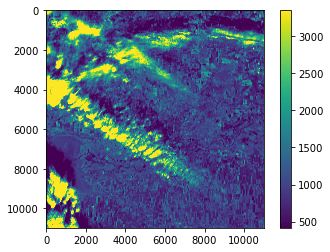

In [36]:
# Нарисуем прочитанный канал
plt.close()
plt.imshow(red_band_array, vmin=np.percentile(red_band_array, 5), vmax=np.percentile(red_band_array, 95))
plt.colorbar()
plt.show()

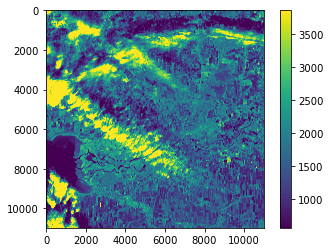

In [37]:
# Также читаем и рисуем ближний ИК канал
nir_band_ds = gdal.Open(nir_band_file)
nir_band = nir_band_ds.GetRasterBand(1)
nir_band_array = nir_band.ReadAsArray()
plt.close()
plt.imshow(nir_band_array, vmin=np.percentile(nir_band_array, 5), vmax=np.percentile(nir_band_array, 95))
plt.colorbar()
plt.show()

Раз у нас есть матрицы красного и ближнего ИК каналов - давайте посчитаем NDVI!

NDVI = (NIR - RED) / (NIR + RED)

In [38]:
ndvi_array = (nir_band_array - red_band_array) / (nir_band_array + red_band_array)
print (ndvi_array)

[[1.90694127e-01 2.17324645e-01 2.16718266e-01 ... 1.32947977e-01
  1.57813703e-01 1.35951662e-01]
 [2.15642458e-01 2.10646388e-01 2.11149294e-01 ... 1.42292490e-01
  1.41868512e-01 1.07482993e-01]
 [2.06083650e-01 1.90277250e-01 1.97309417e-01 ... 1.24533001e-01
  1.33663366e-01 1.20496894e-01]
 ...
 [9.31829328e-03 1.71129117e+01 1.76256742e+01 ... 2.09523810e-01
  1.92214112e-01 2.06006006e-01]
 [1.70562793e+01 1.80258953e+01 1.82269939e+01 ... 2.42325278e-01
  2.48366013e-01 2.53549696e-01]
 [1.83053691e+01 1.90174317e+01 1.91369222e+01 ... 2.84146341e-01
  3.02904564e-01 3.08593750e-01]]


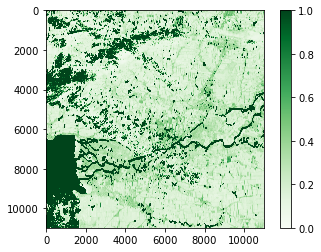

In [40]:
# И нарисуем
plt.close()
plt.imshow(ndvi_array, vmin=0, vmax=1, cmap='Greens')
plt.colorbar()
plt.show()

In [41]:
# Теперь займем облаками
# Читаем канал
cloud_ds = gdal.Open(cloud_band_file)

# А теперь нам нужно привести его к разрешению 10метров (из 60-ти). С помощью GDAL - одной командой!
cloud_10m_ds = gdal.Warp('', cloud_ds, format='MEM', xRes=10, yRes=10)

# Читаем массив
cloud_10m_ds_array = cloud_10m_ds.GetRasterBand(1).ReadAsArray()

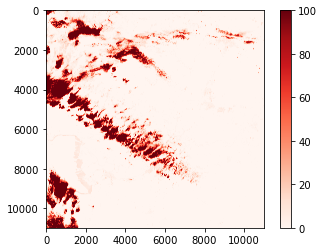

In [42]:
# Нарисуем - это матрица содержит проценты вероятности наличия облачного покрова
plt.close()
plt.imshow(cloud_10m_ds_array, vmin=0, vmax=100, cmap='Reds')
plt.colorbar()
plt.show()

In [45]:
# Можно привести к бинарной маске, установив порог 30%
cloud_mask = np.zeros_like(cloud_10m_ds_array)
cloud_mask[cloud_10m_ds_array>30] = 1

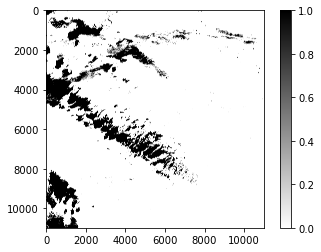

In [46]:
plt.close()
plt.imshow(cloud_mask, vmin=0, vmax=1, cmap='binary')
plt.colorbar()
plt.show()

In [49]:
# В общем-то, цельные снимки нам ни к чему - нас интересует наша маленькая территория, описанная в слое
# Посмотрим, как обрезать данные по векторному слою
# Здесь нам снова поможет GDAL, с помощью утилиты Warp подобные преобразования выполняются очень легко

red_band_ds_cutted = gdal.Warp('',red_band_ds, format='MEM', cutlineDSName = 'data/region.geojson', cutlineLayer = region_layer.GetName(), cropToCutline=True, dstNodata=0)

In [50]:
# Посмотрим, что теперь в этом датасете
red_band_ds_cutted_array = red_band_ds_cutted.GetRasterBand(1).ReadAsArray()

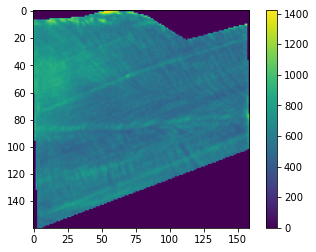

In [51]:
plt.close()
plt.imshow(red_band_ds_cutted_array)
plt.colorbar()
plt.show()

In [63]:
# Отлично, остался только растр в пределах нашего векторного объекта.
# Посчитаем так ndvi и маскируем его маской облачности

# Обрезаем ближний ИК канал
nir_band_ds_cutted = gdal.Warp('',nir_band_ds, format='MEM', cutlineDSName = 'data/region.geojson', cutlineLayer = region_layer.GetName(), cropToCutline=True, dstNodata=0)
nir_band_ds_cutted_array = nir_band_ds_cutted.GetRasterBand(1).ReadAsArray()

# Обрезаем канал с облачностью
cloud_band_ds_cutted = gdal.Warp('',cloud_10m_ds, format='MEM', cutlineDSName = 'data/region.geojson', cutlineLayer = region_layer.GetName(), cropToCutline=True, dstNodata=0)
cloud_band_ds_cutted_array = cloud_band_ds_cutted.GetRasterBand(1).ReadAsArray()
# Маску облачности бинаризируем по порогу 30%
cloud_mask = np.zeros_like(cloud_band_ds_cutted_array)
cloud_mask[cloud_band_ds_cutted_array > 30] = 1

# Считаем NDVI
ndvi_cutted = (nir_band_ds_cutted_array - red_band_ds_cutted_array) / (nir_band_ds_cutted_array + red_band_ds_cutted_array)

# Маскируем матрицу NDVI по маске облаков
ndvi_cutted[cloud_mask==1] = np.nan

<ipython-input-63-7d40d5a19f45>:16: RuntimeWarning: invalid value encountered in true_divide
  ndvi_cutted = (nir_band_ds_cutted_array - red_band_ds_cutted_array) / (nir_band_ds_cutted_array + red_band_ds_cutted_array)


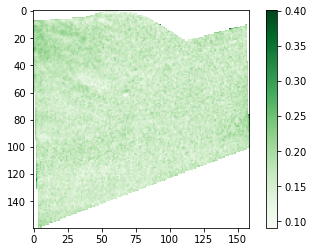

In [65]:
# рисуем!
plt.close()
plt.imshow(ndvi_cutted, cmap='Greens')
plt.colorbar()
plt.show()

In [68]:
# извлекаем статистику
print('Среднее: %s' % np.nanmean(ndvi_cutted))
print('Медиана: %s' % np.nanmedian(ndvi_cutted))
print('Минимальное: %s' % np.nanmin(ndvi_cutted))
print('Максимальное: %s' % np.nanmax(ndvi_cutted))
print('Минимальное с отсечкой: %s' % np.nanpercentile(ndvi_cutted, 5))
print('Максимальное с отсечкой: %s' % np.nanpercentile(ndvi_cutted, 95))
print('Стандартное отклонение: %s' % np.nanstd(ndvi_cutted))

Среднее: 0.16503818884547308
Медиана: 0.16393442622950818
Минимальное: 0.09090909090909091
Максимальное: 0.4007352941176471
Минимальное с отсечкой: 0.134495984158709
Максимальное с отсечкой: 0.1991910952083949
Стандартное отклонение: 0.020221854701282405


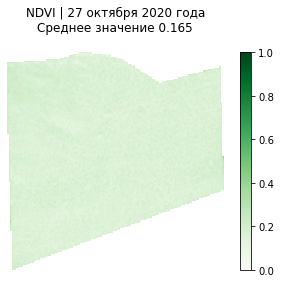

In [87]:
## Немного иначе оформим картинку
# Уберем оси с номерами пикселей, сделаем статичную шкалу, добавим заголовок

plt.close()
plt.imshow(ndvi_cutted, cmap='Greens', vmin=0, vmax=1)
plt.axis('off')
plt.colorbar()
plt.title('NDVI | 27 октября 2020 года\nСреднее значение %s\n' % round(np.nanmean(ndvi_cutted),3))
plt.show()

In [90]:
# И ещё на всякий случай научимся сохранять обрезанные ndvi-матрицы в геотифы - чтобы можно было их потом смотреть в ГИС
# Создаём драйвер
drv = gdal.GetDriverByName('GTiff')

# Создаем базовый набор, опираясь на существующий обрезанный по красному каналу
export_ds = drv.Create('data/ndvi_export.tif', red_band_ds_cutted.RasterXSize, red_band_ds_cutted.RasterYSize, 1, gdal.GDT_Float32 )
export_ds.SetProjection( red_band_ds_cutted.GetProjection() )
export_ds.SetGeoTransform( red_band_ds_cutted.GetGeoTransform() )

# Записываем матрицу NDVI
export_ds.GetRasterBand( 1 ).WriteArray( ndvi_cutted )

# Удаляем переменную, чтобы произошла запись на диск
export_ds = None

Теперь у нас есть всё, чтобы из разобранных фрагментов собрать простую систему мониторинга!

Сделаем это в новой тетрадке: 2_monitoring_system.ipynb